In [1]:
import sys
sys.path.append('../')
import numpy as np
import time
import tt

from mesh.read_starcd import Mesh

import solver.solver_tt as Boltzmann
import pickle

# compute parameters for flow around cylinder

# Parameters for argon (default)
gas_params = Boltzmann.GasParams()

Mach = 6.5
Kn = 0.564
delta = 8.0 / (5 * np.pi**0.5 * Kn)
n_l = 2e+23
T_l = 200.
u_l = Mach * ((gas_params.g * gas_params.Rg * T_l) ** 0.5)
T_w = 5.0 * T_l

n_s = n_l
T_s = T_l

p_s = gas_params.m * n_s * gas_params.Rg * T_s

v_s = np.sqrt(2. * gas_params.Rg * T_s)
mu_s = gas_params.mu(T_s)

l_s = delta * mu_s * v_s / p_s

n_r = (gas_params.g + 1.) * Mach * Mach / ((gas_params.g - 1.) * Mach * Mach + 2.) * n_l
u_r = ((gas_params.g - 1.) * Mach * Mach + 2.) / ((gas_params.g + 1.) * Mach * Mach) * u_l
T_r = (2. * gas_params.g * Mach * Mach - (gas_params.g - 1.)) * ((gas_params.g - 1.) * Mach * Mach + 2.) / ((gas_params.g + 1) ** 2 * Mach * Mach) * T_l

#print 'l_s = ', l_s

#print 'v_s = ', v_s

nv = 44
vmax = 22 * v_s

hv = 2. * vmax / nv
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, nv) # coordinates of velocity nodes

v = Boltzmann.VelocityGrid(vx_, vx_, vx_)

def f_init(x, y, z, v):
    if (x <= 0.):
        return Boltzmann.f_maxwell_tt(v, n_l, u_l, 0., 0., T_l, gas_params.Rg)
    else:
        return Boltzmann.f_maxwell_tt(v, n_r, u_r, 0., 0., T_r, gas_params.Rg)

f_in = Boltzmann.f_maxwell_tt(v, n_l, u_l, 0., 0., T_l, gas_params.Rg)
f_out = Boltzmann.f_maxwell_tt(v, n_r, u_r, 0., 0., T_r, gas_params.Rg)

#print(f_bound)
fmax = Boltzmann.f_maxwell_tt(v, 1., 0., 0., 0., T_w, gas_params.Rg)
#print(fmax)
problem = Boltzmann.Problem(bc_type_list = ['sym-z', 'in', 'out', 'wall', 'sym-y'],
                                bc_data = [[],
                                           [f_in],
                                           [f_out],
                                           [fmax],
                                           []], f_init = f_init)


#print 'vmax =', vmax

config = Boltzmann.Config(solver = 'impl', CFL = 50., tol = 1e-3, tec_save_step = 10)

path = '../mesh/mesh-shock/'
mesh = Mesh()
mesh.read_starcd(path, l_s)

# =============================================================================
# f = open('../mesh/mesh-cyl/mesh-cyl.pickle', 'rb')
#
# mesh = pickle.load(file = f)
#
# f.close()
# =============================================================================

print 'Initialization...'
t1 = time.clock()
S = Boltzmann.Solution(gas_params, problem, mesh, v, config)
t2 = time.clock()
print 'Complete! Took', str(t2 - t1), 'seconds'

('Number of boundary faces = ', 322)
('Number of boundary conditions = ', 4)
('Number of cells = ', 80)
('Number of vertices = ', 324)
('Number of faces = ', 401)
('sum of volumes:', 4.910813089423168e-14)
Initialization...
Complete! Took 14.549236 seconds


In [4]:
# reconstruction for inner faces
# 1st order
for ic in range(S.mesh.nc):
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        if (S.mesh.cell_face_normal_direction[ic, j] == 1):
            S.f_minus[jf] = S.f[ic].copy()
        else:
            S.f_plus[jf] = S.f[ic].copy()

# boundary condition
# loop over all boundary faces
for j in range(S.mesh.nbf):
    jf = S.mesh.bound_face_info[j, 0] # global face index
    bc_num = S.mesh.bound_face_info[j, 1]
    bc_type = S.problem.bc_type_list[bc_num]
    bc_data = S.problem.bc_data[bc_num]
    if (S.mesh.bound_face_info[j, 2] == 1):
        S.f_plus[jf] = Boltzmann.set_bc(S.gas_params, bc_type, bc_data, S.f_minus[jf], S.v, S.vn[jf], S.vnp[jf], S.vnm[jf], config.tol)
    else:
        S.f_minus[jf] = Boltzmann.set_bc(S.gas_params, bc_type, bc_data, S.f_plus[jf], S.v, -S.vn[jf], -S.vnm[jf], -S.vnp[jf], config.tol)

# riemann solver - compute fluxes
for jf in range(S.mesh.nf):
    S.flux[jf] = 0.5 * S.mesh.face_areas[jf] * \
    ((S.f_plus[jf] + S.f_minus[jf]) * S.vn[jf]  - (S.f_plus[jf] - S.f_minus[jf]) * S.vn_abs[jf])
    S.flux[jf] = S.flux[jf].round(config.tol)

# computation of the right-hand side
for ic in range(S.mesh.nc):
    S.rhs[ic] = S.v.zero.copy()
    # sum up fluxes from all faces of this cell
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        S.rhs[ic] += -(S.mesh.cell_face_normal_direction[ic, j]) * (1. / S.mesh.cell_volumes[ic]) * S.flux[jf]
        S.rhs[ic] = S.rhs[ic].round(config.tol)
    # Compute macroparameters and collision integral
    J, S.n[ic], S.ux[ic], S.uy[ic], S.uz[ic], S.T[ic], S.rho[ic], S.p[ic], S.nu[ic] = \
    Boltzmann.comp_j(S.f[ic], S.v, S.gas_params)
    S.rhs[ic] += J
    S.rhs[ic] = S.rhs[ic].round(config.tol)

In [5]:
for ic in range(S.mesh.nc - 1, -1, -1):
    print(ic, (S.rhs[ic]).norm())
    S.df[ic] = S.rhs[ic].copy()

(79, 48206176558.67838)
(78, 48228412952.63393)
(77, 48206176558.67838)
(76, 48350786290.01793)
(75, 48198755506.356445)
(74, 48350786290.01793)
(73, 48350786290.01793)
(72, 48198755506.356445)
(71, 48198755506.356445)
(70, 48350786290.01793)
(69, 48350786290.01793)
(68, 48350786290.01793)
(67, 48198755506.356445)
(66, 48239022421.79561)
(65, 48350786290.01793)
(64, 48198755506.356445)
(63, 48350786290.01793)
(62, 48350786290.01793)
(61, 48350786290.01793)
(60, 48198755506.356445)
(59, 48350786290.01793)
(58, 48112140545.98231)
(57, 48272442080.50911)
(56, 48304651018.88228)
(55, 48107857677.89178)
(54, 48304651018.88228)
(53, 48193968363.23307)
(52, 48189365237.70702)
(51, 48304651018.88228)
(50, 48304651018.88228)
(49, 48328997420.83674)
(48, 48304651018.88228)
(47, 48107857677.89178)
(46, 48318344405.96802)
(45, 48304651018.88228)
(44, 48313078213.69472)
(43, 48313078213.69472)
(42, 48180711375.00759)
(41, 48253109071.240364)
(40, 1.0179189913605225e+24)
(39, 5.6144247539695436e+22)

In [6]:
for ic in range(S.mesh.nc - 1, -1, -1):
    print(ic)
    # loop over neighbors of cell ic
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        icn = S.mesh.cell_neighbors_list[ic, j] # index of neighbor
        if (S.mesh.cell_face_normal_direction[ic, j] == 1):
            vnm_loc = 0.5 * (S.vn[jf] - S.vn_abs_r1) # vnm[jf]
        else:
            vnm_loc = - 0.5 * (S.vn[jf] + S.vn_abs_r1) # -vnp[jf]
        if ((icn >= 0 ) and (icn > ic)):
            print('    ', icn)
            S.df[ic] += - (S.mesh.face_areas[jf] / S.mesh.cell_volumes[ic]) \
            * vnm_loc * S.df[icn]
            S.df[ic] = S.df[ic].round(config.tol)
    # divide by diagonal coefficient
    diag_temp = ((1./S.tau + S.nu[ic]) * S.v.ones + S.diag_r1[ic]).round(1e-3, rmax = 1)
    S.df[ic] = Boltzmann.div_tt(S.df[ic], diag_temp)
    S.df[ic] = S.df[ic].round(config.tol)

79
78
('    ', 79)
77
('    ', 78)
76
('    ', 77)
75
('    ', 76)
74
('    ', 75)
73
('    ', 74)
72
('    ', 73)
71
('    ', 72)
70
('    ', 71)
69
('    ', 70)
68
('    ', 69)
67
('    ', 68)
66
('    ', 67)
65
('    ', 66)
64
('    ', 65)
63
('    ', 64)
62
('    ', 63)
61
('    ', 62)
60
('    ', 61)
59
('    ', 60)
58
('    ', 59)
57
('    ', 58)
56
('    ', 57)
55
('    ', 56)
54
('    ', 55)
53
('    ', 54)
52
('    ', 53)
51
('    ', 52)
50
('    ', 51)
49
('    ', 50)
48
('    ', 49)
47
('    ', 48)
46
('    ', 47)
45
('    ', 46)
44
('    ', 45)
43
('    ', 44)
42
('    ', 43)
41
('    ', 42)
40
('    ', 41)
39
('    ', 40)
38
('    ', 39)
37
('    ', 38)
36
('    ', 37)
35
('    ', 36)
34
('    ', 35)
33
('    ', 34)
32
('    ', 33)
31
('    ', 32)
30
('    ', 31)
29
('    ', 30)
28
('    ', 29)
27
('    ', 28)
26
('    ', 27)
25
('    ', 26)
24
('    ', 25)
23
('    ', 24)
22
('    ', 23)
21
('    ', 22)
20
('    ', 21)
19
('    ', 20)
18
('    ', 19)
17
('    ', 18)
16
('

In [ ]:
for ic in range(S.mesh.nc - 1, -1, -1):
    print(ic, (S.rhs[ic]).norm())

In [7]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np
from matplotlib import rcParams
import pickle

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


X = v.vx[:, 0, 0]
Y = v.vy[0, :, 0]

X, Y = np.meshgrid(X, Y)

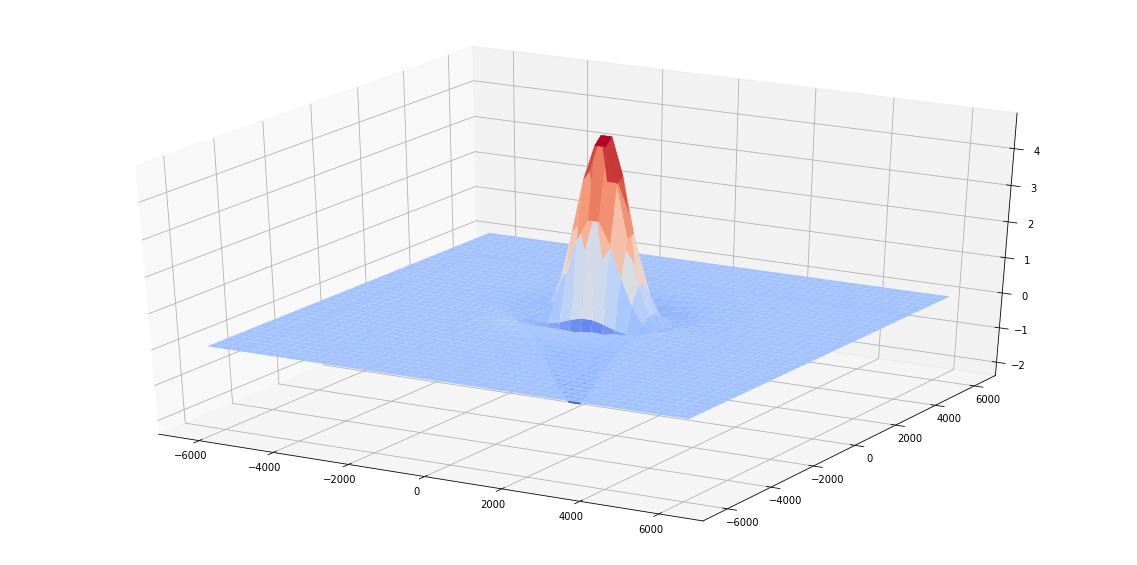

In [11]:
fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(1, 1, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, S.df[60].full()[:, :, nv//2], cmap=cm.coolwarm, linewidth=0, antialiased=True)
#ax1.zaxis.set_scale('log')
plt.show()

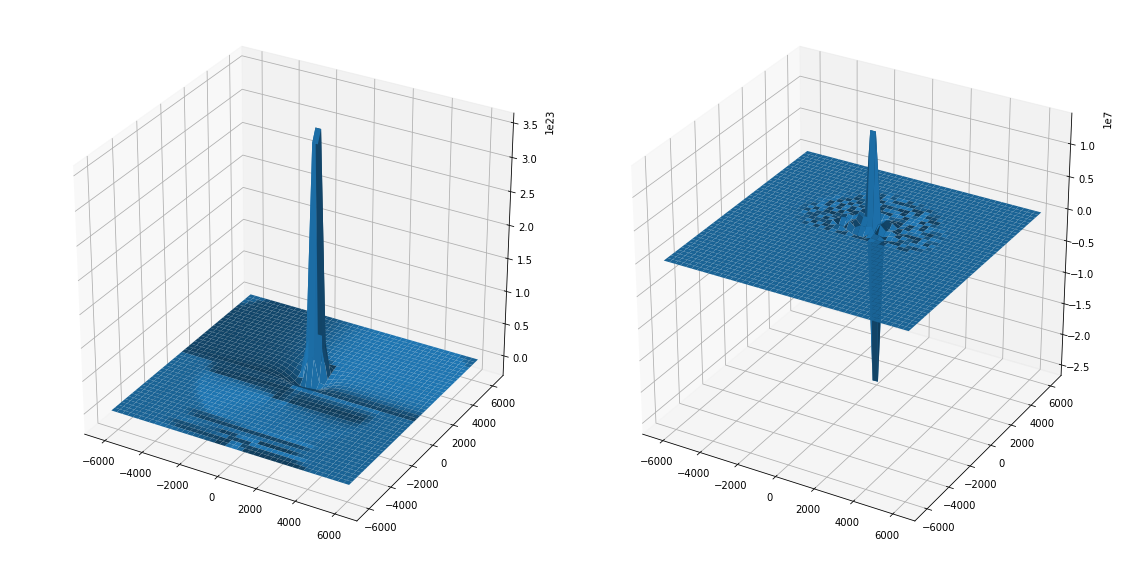

In [10]:
A = S.rhs[40].copy()
B = A.copy()

B = B - B

fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, A.full()[:, :, nv//2])

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, B.full()[:, :, nv//2])

fig.subplots_adjust(wspace = 0.)

#plt.show()
#plt.savefig('diag.eps', dpi = 600, bbox_inches='tight')
plt.savefig('diag.png', dpi = 100, bbox_inches='tight')

In [ ]:
for ic in range(S.mesh.nc - 1, -1, -1):
    print(ic, (S.vn[ic]).norm())

In [ ]:
A = (S.vn[267] - S.vn_abs_r1).copy()
B = v.zero.copy()

fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, A.full()[:, :, nv//2])

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, B.full()[:, :, nv//2])

fig.subplots_adjust(wspace = 0.)

#plt.show()
#plt.savefig('diag.eps', dpi = 600, bbox_inches='tight')
plt.savefig('diag.png', dpi = 100, bbox_inches='tight')